# 🧱 GANs on Lego Data - Training

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the GAN](#build)
3. [Train the GAN](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU, ReLU, UpSampling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
Z_DIM = 100
EPOCHS = 100
NUM_FEATURES = 64

## 1. Prepare the data <a name="prepare"></a>

In [4]:
train_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.
Using 32000 files for training.


2022-04-17 18:35:24.984655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 18:35:24.993503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 18:35:24.994218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 18:35:24.995560: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 40000 files belonging to 1 classes.
Using 8000 files for validation.


In [5]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

In [6]:
train_sample = sample_batch(train)
test_sample = sample_batch(test)

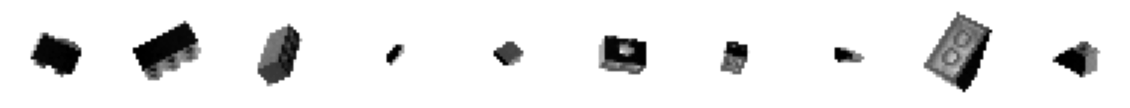

In [7]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [8]:

# discriminator_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
# x = Conv2D(64, kernel_size=5, strides=2, padding="same")(discriminator_input)
# # x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Dropout(0.3)(x)
# x = Conv2D(128, kernel_size=5, strides=2, padding="same")(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Dropout(0.3)(x)
# x = Flatten()(x)
# discriminator_output = Dense(1)(x)

# discriminator = Model(discriminator_input, discriminator_output)
# discriminator.summary()

discriminator_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=2, padding="same")(discriminator_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Flatten()(x)
discriminator_output = Dense(1)(x)

discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                             

In [9]:
# generator_input = Input(shape=(Z_DIM,))
# x = Dense(8 * 8 * 256, use_bias=False)(generator_input)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Reshape((8, 8, 256))(x)
# x = Conv2D(128, kernel_size=5, strides=1, use_bias=False, padding="same")(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = UpSampling2D()(x)
# x = Conv2D(64, kernel_size=5, strides=1, use_bias=False, padding="same")(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = UpSampling2D()(x)
# generator_output = Conv2D(CHANNELS, kernel_size=5, strides = 1, use_bias=False, padding="same", activation="tanh")(x)
# generator = Model(generator_input, generator_output)
# generator.summary()

generator_input = Input(shape=(Z_DIM,))
x = Dense(4*4*NUM_FEATURES)(generator_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Reshape((4, 4, NUM_FEATURES))(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
generator_output = Conv2D(CHANNELS, kernel_size=5, padding="same", activation="tanh")(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              103424    
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 64)         0         
 )                                                         

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def discriminator_loss(self, real_predictions, fake_predictions):
        real_labels = tf.zeros_like(real_predictions) + 0.05 * tf.random.uniform(tf.shape(real_predictions))
        real_loss = self.loss_fn(real_labels, real_predictions)
        fake_labels = tf.ones_like(fake_predictions) + 0.05 * tf.random.uniform(tf.shape(fake_predictions))
        fake_loss = self.loss_fn(fake_labels, fake_predictions)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def generator_loss(self, fake_predictions):
        return self.loss_fn(tf.zeros_like(fake_predictions), fake_predictions)

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training = True)
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(generated_images, training = True)
            g_loss = self.generator_loss(fake_predictions)
            d_loss = self.discriminator_loss(real_predictions, fake_predictions)
            
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## 3. Train the GAN <a name="train"></a>

In [11]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [18]:
gan.compile(
    d_optimizer=Adam(learning_rate=0.00005),
    g_optimizer=Adam(learning_rate=0.0002),
    loss_fn=BinaryCrossentropy(from_logits = True),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs2")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        


Epoch 271/1000
 998/1000 [============================>.] - ETA: 0s - d_loss: 0.0172 - g_loss: 7.0767
Saved to ./output/generated_img_270.png


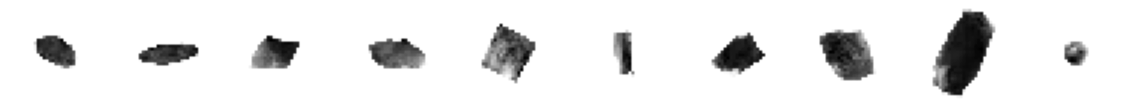

1000/1000 [==============================] - 33s 30ms/step - d_loss: 0.0171 - g_loss: 7.0792
Epoch 272/1000
 998/1000 [============================>.] - ETA: 0s - d_loss: 0.0024 - g_loss: 7.4285
Saved to ./output/generated_img_271.png


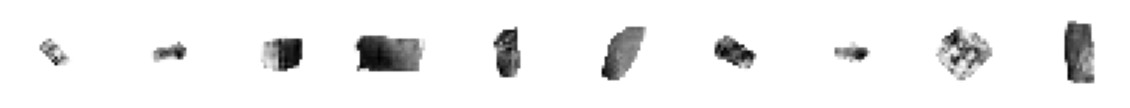

1000/1000 [==============================] - 30s 30ms/step - d_loss: 0.0024 - g_loss: 7.4318
Epoch 273/1000
1000/1000 [==============================] - ETA: 0s - d_loss: 0.0027 - g_loss: 7.6237
Saved to ./output/generated_img_272.png


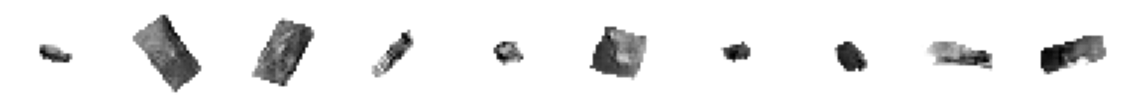

1000/1000 [==============================] - 30s 30ms/step - d_loss: 0.0027 - g_loss: 7.6237
Epoch 274/1000
 685/1000 [===================>..........] - ETA: 9s - d_loss: 0.0075 - g_loss: 7.7271

In [ ]:
history = gan.fit(
    train, 
    epochs=EPOCHS*10, 
    # steps_per_epoch = 100, 
    initial_epoch = 270,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [19]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

2022-04-17 20:56:13.549073: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/generator/assets
INFO:tensorflow:Assets written to: ./models/discriminator/assets
